In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal as sig
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy import fft

from processing_helpers import do_linear_regression
from processing_helpers import get_residuals

In [2]:
#initial constants
delta_t = 0.00025

nb_ptw = 2.048 #seconds

rrc_con_nb_t = int(20.48/delta_t)

#voltage
V = 3.7

ptw_disc = int(nb_ptw/delta_t) #timesteps
msg_interval = 40000 #timesteps

to_uWh = (1000*1000*delta_t*V)/3600



nb_active_energy = 30 #uWh
ltem_active_energy = 100 #uWh

In [3]:
##CoAP 
coap_byte_step = 41

sweep_file1 = "../measurements/otii/sweep_coap_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_coap_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_coap_psm_test03.csv" 


coap_nb_data = []
coap_nb_data.append(pd.read_csv(sweep_file1))
coap_nb_data.append(pd.read_csv(sweep_file2))
coap_nb_data.append(pd.read_csv(sweep_file3))


sweep_file1 = "../measurements/otii/sweep_ltem_coap_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_ltem_coap_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_ltem_coap_psm_test03.csv"
sweep_file4 = "../measurements/otii/sweep_ltem_coap_psm_test04.csv"


coap_ltem_data = []
coap_ltem_data.append(pd.read_csv(sweep_file1))
coap_ltem_data.append(pd.read_csv(sweep_file2))
coap_ltem_data.append(pd.read_csv(sweep_file3))
coap_ltem_data.append(pd.read_csv(sweep_file4))


In [4]:
##MQTT
mqtt_byte_step = 64

sweep_file1 = "../measurements/otii/sweep_mqtt_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_mqtt_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_mqtt_psm_test03.csv" 


mqtt_data = []
mqtt_data.append(pd.read_csv(sweep_file1))
mqtt_data.append(pd.read_csv(sweep_file2))
mqtt_data.append(pd.read_csv(sweep_file3))

sweep_file1 = "../measurements/otii/sweep_ltem_mqtt_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_ltem_mqtt_psm_test02.csv"
sweep_file3 = "../measurements/otii/sweep_ltem_mqtt_psm_test03.csv"

mqtt_ltem_data = []
mqtt_ltem_data.append(pd.read_csv(sweep_file1))
mqtt_ltem_data.append(pd.read_csv(sweep_file2))
mqtt_ltem_data.append(pd.read_csv(sweep_file3))



In [5]:
coap_nb_energy = []
coap_nb_current = []
for i in coap_nb_data:
    coap_nb_energy.append(i["Arc Main Energy (J)"])
    coap_nb_current.append(i["Arc Main Current (A)"])

mqtt_nb_energy = []
mqtt_nb_current = []
for i in mqtt_data:
    mqtt_nb_energy.append(i["Arc Main Energy (J)"])
    mqtt_nb_current.append(i["Arc Main Current (A)"])

coap_ltem_energy = []
coap_ltem_current = []
for i in coap_ltem_data:
    coap_ltem_energy.append(i["Arc Main Energy (J)"])
    coap_ltem_current.append(i["Arc Main Current (A)"])

mqtt_ltem_energy = []
mqtt_ltem_current = []
for i in mqtt_ltem_data:
    mqtt_ltem_energy.append(i["Arc Main Energy (J)"])
    mqtt_ltem_current.append(i["Arc Main Current (A)"])

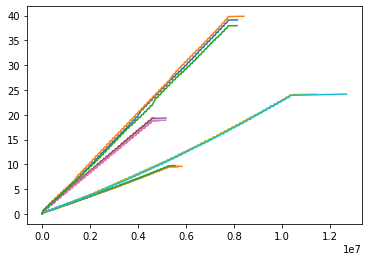

In [6]:
plt.figure()
for i in coap_nb_energy:
    i.plot()

for i in coap_ltem_energy:
    i.plot()

for i in mqtt_nb_energy:
    i.plot()

for i in mqtt_ltem_energy:
    i.plot()   

In [7]:
segments_coap_nb = []
timing_coap_nb = []

in_segment = False
segment_start = 0

idx = 0
for batch in coap_nb_current:
    print("Batch: " + str(idx))
    curr_set = []
    i = 160000 
    curr_timing = []
    endpoint = (batch.index.size)
    while(i < endpoint):
        curr_meas = batch.iloc[i]
        if(curr_meas > 0.04):
            if(in_segment):
                curr_timing.append(i-segment_start)
                i+=20000 #inbetween messages
                in_segment = False
            else:
                curr_set.append(batch.iloc[(i-400):(i+120000)])
                segment_start = i
                i+=rrc_con_nb_t
                in_segment = True
        else:
            i += 1
    timing_coap_nb.append(curr_timing) 
    segments_coap_nb.append(curr_set)
    idx += 1

Batch: 0
Batch: 1
Batch: 2


36
36
36


Text(0.5, 0, 'Payload size [Bytes]')

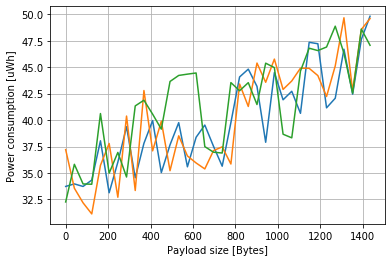

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#coap_nb_sums = np.zeros((len(segments_coap_nb[0]), len(segments_coap_nb)))
coap_nb_sums = []

bytes_coap = range(0,coap_byte_step*len(segments_coap_nb[0]), coap_byte_step)

for i in segments_coap_nb:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - nb_active_energy
        sum_acc.append(curr_sum)
        #coap_nb_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_coap,sum_acc, label = str(idx_seg))
    coap_nb_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [9]:
coap_nb_stds = []
coap_nb_avg = []


for i in range(len(coap_nb_sums[0])):
    curr_sample = []
    for j in range(len(coap_nb_sums)):
        curr_sample.append(coap_nb_sums[j][i])
    coap_nb_avg.append(np.mean(curr_sample))
    coap_nb_stds.append(np.std(curr_sample))
   
print(np.mean(coap_nb_stds))
print(coap_nb_avg[1])

1.8475417655030695
34.45358489417361


In [10]:
segments_coap_ltem = []
timing_coap_ltem = []

idx = 0
indexes_coap_ltem = []

before_segment = True

for batch in coap_ltem_current:
    print("Batch: " + str(idx))
    curr_set = []
    curr_timing = []
    i = 100000 
    endpoint = (batch.index.size)
    while(i < endpoint):
        curr_meas = batch.iloc[i]
        if(before_segment):
            if(curr_meas > 0.05):    
                curr_set.append(batch.iloc[(i-400):(i+60000)])
                segment_start = i
                i+=60000
                before_segment = False
            else:
                i += 1
        else:
            if(curr_meas > 0.01):
                curr_timing.append(i - segment_start)
                i+=40000
                before_segment = True
            else:
                i-=1
    
    segments_coap_ltem.append(curr_set)
    timing_coap_ltem.append(curr_timing)
    idx += 1

Batch: 0
Batch: 1
Batch: 2
Batch: 3


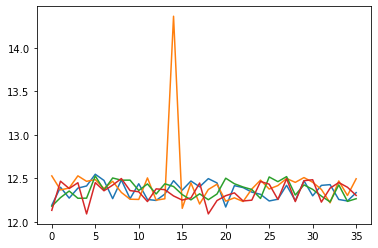

In [11]:
plt.figure()
for i in timing_coap_ltem:
    plt.plot(np.array(i)*delta_t)

36
36
36
36


Text(0.5, 0, 'Payload size [Bytes]')

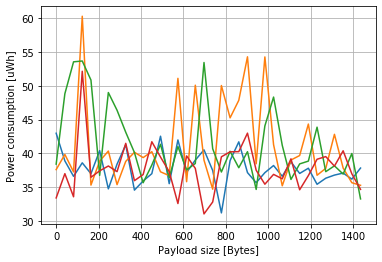

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#coap_ltem_sums = np.zeros((len(segments_coap_ltem[0]), len(segments_coap_ltem)))
coap_ltem_sums = []

for i in segments_coap_ltem:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - ltem_active_energy
        sum_acc.append(curr_sum)
        #coap_ltem_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_coap,sum_acc, label = str(idx_seg))
    coap_ltem_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [47]:
coap_ltem_stds = []
coap_ltem_avg = []


for i in range(len(coap_ltem_sums[0])):
    curr_sample = []
    for j in range(len(coap_ltem_sums)):
        curr_sample.append(coap_ltem_sums[j][i])
    coap_ltem_avg.append(np.mean(curr_sample))
    coap_ltem_stds.append(np.std(curr_sample))
   
print(np.mean(coap_ltem_stds))
print(coap_ltem_avg[1])

3.540796749824951
41.13199694390625


In [14]:
segments_mqtt_nb = []
timing_mqtt_nb = []

in_segment = False
segment_start = 0

idx = 0
indexes_mqtt_nb = []
for batch in mqtt_nb_current:
    print("Batch: " + str(idx))
    curr_set = []
    curr_timing = []

    i = 180000 
    endpoint = (batch.index.size)
    while(i < endpoint):
        curr_meas = batch.iloc[i]
        if(curr_meas > 0.04): 
            if(in_segment):
                curr_timing.append(i-segment_start)
                i+=20000 #inbetween messages
                in_segment = False
            else:
                curr_set.append(batch.iloc[(i-400):(i+120000)])
                segment_start = i
                i+=rrc_con_nb_t
                in_segment = True
        else:
            i += 1
    timing_mqtt_nb.append(curr_timing)
    segments_mqtt_nb.append(curr_set)
    idx += 1

Batch: 0
Batch: 1
Batch: 2


64
64
64


Text(0.5, 0, 'Payload size [Bytes]')

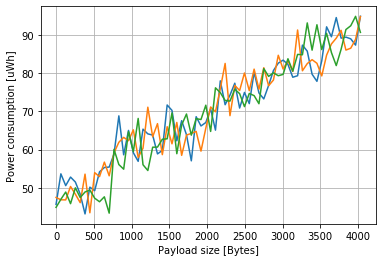

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#mqtt_nb_sums = np.zeros((len(segments_mqtt_nb[0]), len(segments_mqtt_nb)))

mqtt_nb_sums = []
bytes_mqtt = range(0,mqtt_byte_step*len(segments_mqtt_nb[0]), mqtt_byte_step)

for i in segments_mqtt_nb:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - nb_active_energy
        sum_acc.append(curr_sum)
        #mqtt_nb_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_mqtt,sum_acc, label = str(idx_seg))
    mqtt_nb_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [16]:
mqtt_nb_stds = []
mqtt_nb_avg = []

for i in range(len(mqtt_nb_sums[0])):
    curr_sample = []
    for j in range(len(mqtt_nb_sums)):
        curr_sample.append(mqtt_nb_sums[j][i])
    mqtt_nb_avg.append(np.mean(curr_sample))
    mqtt_nb_stds.append(np.std(curr_sample))
   
print(np.mean(mqtt_nb_stds))
print(mqtt_nb_avg[1])
print(len(mqtt_nb_avg))

2.8525165421716014
49.14779399604398
64


In [17]:
segments_mqtt_ltem = []
timing_mqtt_ltem = []

before_segment = True

idx = 0
for batch in mqtt_ltem_current:
    print("Batch: " + str(idx))
    curr_set = []
    curr_timing = []
    i = 120000 
    index_list = []
    endpoint = (batch.index.size)
    while(i < endpoint):
        curr_meas = batch.iloc[i]
        if(before_segment):
            if(curr_meas > 0.05):    
                curr_set.append(batch.iloc[(i-400):(i+100000)])
                segment_start = i
                i+=80000
                before_segment = False
            else:
                i += 1
        else:
            if(curr_meas > 0.01):
                curr_timing.append(i - segment_start)
                i+=40000
                before_segment = True
            else:
                i-=1
    segments_mqtt_ltem.append(curr_set)
    timing_mqtt_ltem.append(curr_timing)
    idx += 1

Batch: 0
Batch: 1
Batch: 2


64
64
64


Text(0.5, 0, 'Payload size [Bytes]')

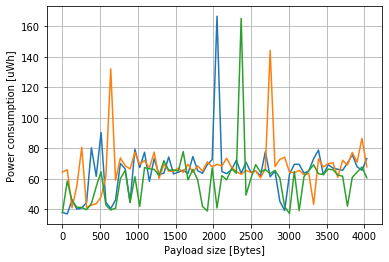

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#mqtt_ltem_sums = np.zeros((len(segments_mqtt_ltem[0]), len(segments_mqtt_ltem)))
mqtt_ltem_sums = []
bytes_mqtt = range(0,mqtt_byte_step*len(segments_mqtt_ltem[0]), mqtt_byte_step)

for i in segments_mqtt_ltem:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - ltem_active_energy
        sum_acc.append(curr_sum)
        #mqtt_ltem_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_mqtt,sum_acc, label = str(idx_seg))
    mqtt_ltem_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [19]:
mqtt_ltem_stds = []
mqtt_ltem_avg = []

for i in range(len(mqtt_ltem_sums[0])):
    curr_sample = []
    for j in range(len(mqtt_ltem_sums)):
        curr_sample.append(mqtt_ltem_sums[j][i])

    mqtt_ltem_avg.append(np.mean(curr_sample))
    mqtt_ltem_stds.append(np.std(curr_sample))
   
print(np.mean(mqtt_ltem_stds))
print(mqtt_ltem_avg[1])
print(len(mqtt_ltem_avg))

8.84256942014797
53.88917223687961
64


In [20]:
coap_ltem_smooth = sig.savgol_filter(coap_ltem_avg,9,3)
coap_nb_smooth = sig.savgol_filter(coap_nb_avg,9,3)
mqtt_nb_smooth = sig.savgol_filter(mqtt_nb_avg,9,3)
mqtt_ltem_smooth = sig.savgol_filter(mqtt_ltem_avg,9,3)

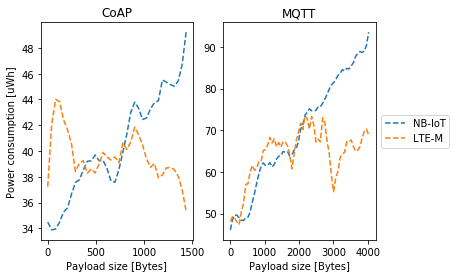

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('CoAP')
ax2.set_title('MQTT')

ax1.set(ylabel="Power consumption [uWh]")
ax1.set_xlabel("Payload size [Bytes]")
ax2.set_xlabel("Payload size [Bytes]")

#plt.plot(bytes_coap, coap_nb_avg   ,     label = "CoAP NB-IoT average")
ax1.plot(bytes_coap, coap_nb_smooth, "--" ,label = "NB-IoT")

#plt.plot(bytes_mqtt, mqtt_nb_avg   ,       label = "MQTT 2300 average")
ax2.plot(bytes_mqtt, mqtt_nb_smooth, "--" ,label = "NB-IoT")

#plt.plot(bytes_coap, coap_ltem_avg   ,     label = "CoAP LTE-M average")
ax1.plot(bytes_coap, coap_ltem_smooth, "--", label = "LTE-M")

#plt.plot(bytes_mqtt, mqtt_ltem_avg   ,       label = "MQTT 2300 average")
ax2.plot(bytes_mqtt, mqtt_ltem_smooth, "--" ,label = "LTE-M")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
timing_coap_nb_res = do_linear_regression(bytes_coap, timing_coap_nb)
timing_mqtt_nb_res = do_linear_regression(bytes_mqtt, timing_mqtt_nb)

timing_coap_ltem_res = do_linear_regression(bytes_coap, timing_coap_ltem)
timing_mqtt_ltem_res = do_linear_regression(bytes_mqtt, timing_mqtt_ltem)

energy_mqtt_nb_res = do_linear_regression(bytes_mqtt, mqtt_nb_sums)
energy_coap_nb_res = do_linear_regression(bytes_coap, coap_nb_sums)

energy_mqtt_ltem_res = do_linear_regression(bytes_mqtt, mqtt_ltem_sums)
energy_coap_ltem_res = do_linear_regression(bytes_coap, coap_ltem_sums)

result_matrix = {
    'timing_coap_nb'   : [timing_coap_nb_res[0][0]  , timing_coap_nb_res[1]],
    'energy_coap_nb'   : [energy_coap_nb_res[0][0]  , energy_coap_nb_res[1]],
    'timing_coap_ltem' : [timing_coap_ltem_res[0][0], timing_coap_ltem_res[1]],
    'energy_coap_ltem' : [energy_coap_ltem_res[0][0], energy_coap_ltem_res[1]],
    'timing_mqtt_nb'   : [timing_mqtt_nb_res[0][0]  , timing_mqtt_nb_res[1]],
    'energy_mqtt_nb'   : [energy_mqtt_nb_res[0][0]  , energy_mqtt_nb_res[1]],
    'timing_mqtt_ltem' : [timing_mqtt_ltem_res[0][0], timing_mqtt_ltem_res[1]],
    'energy_mqtt_ltem' : [energy_mqtt_ltem_res[0][0], energy_mqtt_ltem_res[1]]
}

regression_results = pd.DataFrame(data = result_matrix)


In [50]:
regression_results.to_csv("reg_res.csv")

In [51]:
regression_results

,timing_coap_nb,energy_coap_nb,timing_coap_ltem,energy_coap_ltem,timing_mqtt_nb,energy_mqtt_nb,timing_mqtt_ltem,energy_mqtt_ltem
0,1.497156,0.008578,-0.017853,-0.003060,2.103690,0.011030,1.180229,0.003472
1,109558.223829,34.420137,49509.470959,41.803026,113610.585618,47.358379,53638.893428,55.594851


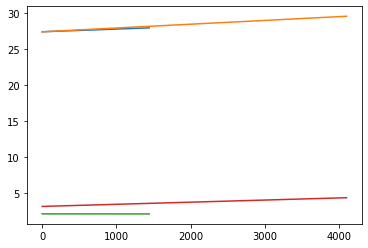

In [52]:
plt.figure()
x_coap_nb_t = np.linspace(0,1440,1440)
y_coap_nb_t = timing_coap_nb_res[0]*x_coap_nb_t+timing_coap_nb_res[1]

x_mqtt_nb_t = np.linspace(0,4096,4096)
y_mqtt_nb_t = timing_mqtt_nb_res[0]*x_mqtt_nb_t+timing_coap_nb_res[1]

x_coap_ltem_t = np.linspace(0,1440,1440)
y_coap_ltem_t = timing_coap_ltem_res[0]*x_coap_ltem_t+timing_coap_ltem_res[1]

x_mqtt_ltem_t = np.linspace(0,4096,4096)
y_mqtt_ltem_t = timing_mqtt_ltem_res[0]*x_mqtt_ltem_t+timing_mqtt_ltem_res[1]

plt.plot(x_coap_nb_t,y_coap_nb_t*delta_t)
plt.plot(x_mqtt_nb_t,y_mqtt_nb_t*delta_t)

plt.plot(x_coap_ltem_t,y_coap_ltem_t*delta_t-10.24) #subtracting the RRC Connected time of LTE-M. This is not consistent though 
plt.plot(x_mqtt_ltem_t,y_mqtt_ltem_t*delta_t-10.24) #subtracting the RRC Connected time of LTE-M. This is not consistent though 

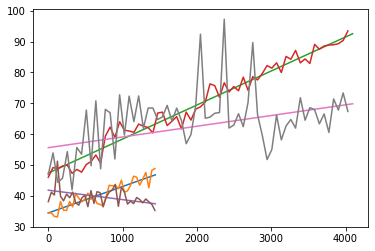

In [53]:
plt.figure()
x_coap_nb = np.linspace(0,1440,1440)
y_coap_nb = energy_coap_nb_res[0]*x_coap_nb+energy_coap_nb_res[1]

x_mqtt_nb = np.linspace(0,4096,4096)
y_mqtt_nb = energy_mqtt_nb_res[0]*x_mqtt_nb+energy_mqtt_nb_res[1]

x_coap_ltem = np.linspace(0,1440,1440)
y_coap_ltem = energy_coap_ltem_res[0]*x_coap_ltem+energy_coap_ltem_res[1]

x_mqtt_ltem = np.linspace(0,4096,4096)
y_mqtt_ltem = energy_mqtt_ltem_res[0]*x_mqtt_ltem+energy_mqtt_ltem_res[1]

plt.plot(x_coap_nb,y_coap_nb)
plt.plot(bytes_coap,coap_nb_avg)

plt.plot(x_mqtt_nb,y_mqtt_nb)
plt.plot(bytes_mqtt,mqtt_nb_avg)

plt.plot(x_coap_ltem,y_coap_ltem)
plt.plot(bytes_coap,coap_ltem_avg)

plt.plot(x_mqtt_ltem,y_mqtt_ltem)
plt.plot(bytes_mqtt,mqtt_ltem_avg)

In [54]:
residuals_coap_nb   = get_residuals(coap_nb_sums,   energy_coap_nb_res,     bytes_coap)
residuals_coap_ltem = get_residuals(coap_ltem_sums, energy_coap_ltem_res,   bytes_coap)
residuals_mqtt_nb   = get_residuals(mqtt_nb_sums,   energy_mqtt_nb_res,     bytes_mqtt)
residuals_mqtt_ltem = get_residuals(mqtt_ltem_sums, energy_mqtt_ltem_res,   bytes_mqtt)

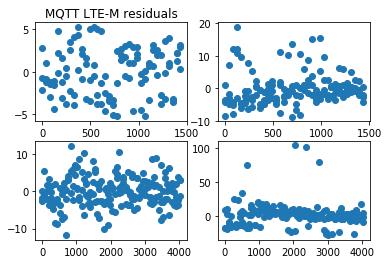

In [55]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

ax1.set_title("Coap NB-IoT residuals")
ax1.set_title("Coap LTE-M residuals")
ax1.set_title("MQTT NB-IoT residuals")
ax1.set_title("MQTT LTE-M residuals")


ax1.scatter(residuals_coap_nb[0],   residuals_coap_nb[1])
ax2.scatter(residuals_coap_ltem[0], residuals_coap_ltem[1])
ax3.scatter(residuals_mqtt_nb[0],   residuals_mqtt_nb[1])
ax4.scatter(residuals_mqtt_ltem[0], residuals_mqtt_ltem[1])


In [58]:
print(len(residuals_coap_nb))
print(len(residuals_coap_ltem)

2
2


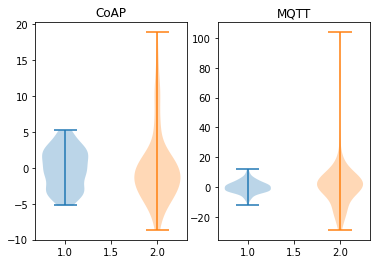

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("CoAP")
ax1.set_xticks([1,2],['NB-IoT', "LTE-M"])
ax2.set_title("MQTT")
ax2.set_xticks([1,2],['NB-IoT', "LTE-M"])

ax1.violinplot(residuals_coap_nb[1], positions = [1])
ax1.violinplot(residuals_coap_ltem[1], positions = [2])



ax2.violinplot(residuals_mqtt_nb[1], positions = [1])
ax2.violinplot(residuals_mqtt_ltem[1], positions = [2])



{'bodies': [<matplotlib.collections.PolyCollection at 0x1a1d3d8550>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a1d2b8b10>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a1d3d8690>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a1d3d83d0>}

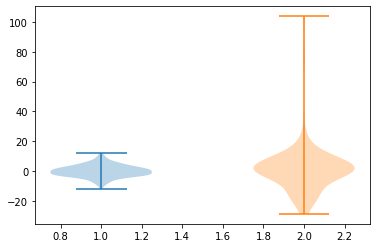

In [60]:
plt.figure()
plt.violinplot(residuals_mqtt_nb[1], positions = [1],   label = "NB-IoT")
plt.violinplot(residuals_mqtt_ltem[1], positions = [2], label = "LTE-M")